# Coloring Black and White Pictures using a Generative Adversarial Network (GAN)

## Preparing the Data set

### Loading and Inspecting the Data

In [101]:
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from skimage.color import rgb2lab, lab2rgb, rgb2gray
from datetime import datetime

In [25]:
(x_tr, y_tr), (x_te, y_te) = keras.datasets.cifar10.load_data()
assert x_tr.shape == (50000, 32, 32, 3)
assert x_te.shape == (10000, 32, 32, 3)
assert y_tr.shape == (50000, 1)
assert y_te.shape == (10000, 1)

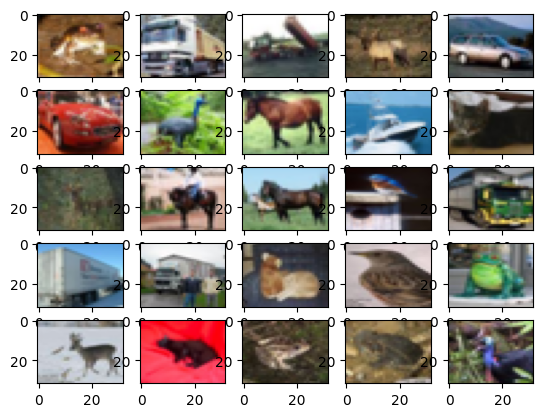

In [4]:
# visualize data by plotting images
fig, ax = plt.subplots(5, 5)
k = 0
 
for i in range(5):
    for j in range(5):
        ax[i][j].imshow(x_tr[k], aspect='auto')
        k += 1
 
plt.show()

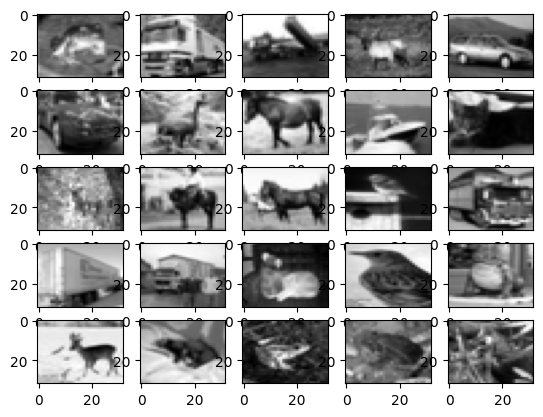

In [14]:
# Display pictures in black and white
fig, ax = plt.subplots(5, 5)
k = 0
 
for i in range(5):
    for j in range(5):
        ax[i][j].imshow(rgb2gray(x_tr[k]), aspect='auto', cmap='gray')
        k += 1
 
plt.show()

### Changing Colors to Black and White

I didn't try the LAB colors yet, as it was easier staying within the RGB realm to visualise and understand the data


In [34]:
x_train = []
y_train = []
for image in x_tr:
    y_train.append(image)
    image_gray = rgb2gray(image)
    x_train.append(image_gray)

x_test = []
y_test = []
for image in x_te:
    y_test.append(image)
    image_gray = rgb2gray(image)
    x_test.append(image_gray)

x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

assert x_train.shape == (50000, 32, 32)
assert x_test.shape == (10000, 32, 32)
assert y_train.shape == (50000, 32, 32, 3)
assert y_test.shape == (10000, 32, 32, 3)

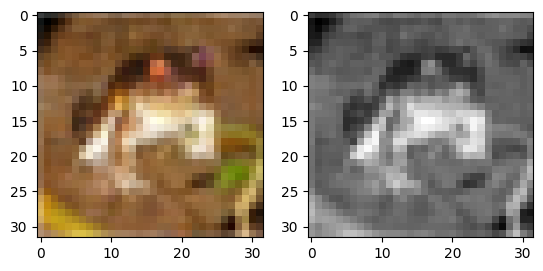

In [49]:
# Visualize an example from the transformed data set
fig, ax = plt.subplots(1,2)
ax[0].imshow(y_train[0])
ax[1].imshow(x_train[0], cmap='gray')
plt.show()

## Setting up the GAN

Code here was take from this source: https://colab.research.google.com/drive/1kMbrig8CMM5f2-hDTISSQmzaslG0LGlJ?usp=sharing

Nothing was really changed. This was done to get a working model which can subsequently be adjusted.

### Generator

In [56]:
# Goes from 1-dimension to three dimensions
inputs = tf.keras.layers.Input( shape=(x_train.shape[1], x_train.shape[2], 1 ) )

conv1 = tf.keras.layers.Conv2D( 16 , kernel_size=( 5 , 5 ) , strides=1 )( inputs )
conv1 = tf.keras.layers.LeakyReLU()( conv1 )
conv1 = tf.keras.layers.Conv2D( 32 , kernel_size=( 3 , 3 ) , strides=1)( conv1 )
conv1 = tf.keras.layers.LeakyReLU()( conv1 )
conv1 = tf.keras.layers.Conv2D( 32 , kernel_size=( 3 , 3 ) , strides=1)( conv1 )
conv1 = tf.keras.layers.LeakyReLU()( conv1 )

conv2 = tf.keras.layers.Conv2D( 32 , kernel_size=( 5 , 5 ) , strides=1)( conv1 )
conv2 = tf.keras.layers.LeakyReLU()( conv2 )
conv2 = tf.keras.layers.Conv2D( 64 , kernel_size=( 3 , 3 ) , strides=1 )( conv2 )
conv2 = tf.keras.layers.LeakyReLU()( conv2 )
conv2 = tf.keras.layers.Conv2D( 64 , kernel_size=( 3 , 3 ) , strides=1 )( conv2 )
conv2 = tf.keras.layers.LeakyReLU()( conv2 )

conv3 = tf.keras.layers.Conv2D( 64 , kernel_size=( 5 , 5 ) , strides=1 )( conv2 )
conv3 = tf.keras.layers.LeakyReLU()( conv3 )
conv3 = tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1 )( conv3 )
conv3 = tf.keras.layers.LeakyReLU()( conv3 )
conv3 = tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1 )( conv3 )
conv3 = tf.keras.layers.LeakyReLU()( conv3 )

bottleneck = tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1 , activation='tanh' , padding='same' )( conv3 )

concat_1 = tf.keras.layers.Concatenate()( [ bottleneck , conv3 ] )
conv_up_3 = tf.keras.layers.Conv2DTranspose( 128 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' )( concat_1 )
conv_up_3 = tf.keras.layers.Conv2DTranspose( 128 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' )( conv_up_3 )
conv_up_3 = tf.keras.layers.Conv2DTranspose( 64 , kernel_size=( 5 , 5 ) , strides=1 , activation='relu' )( conv_up_3 )

concat_2 = tf.keras.layers.Concatenate()( [ conv_up_3 , conv2 ] )
conv_up_2 = tf.keras.layers.Conv2DTranspose( 64 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' )( concat_2 )
conv_up_2 = tf.keras.layers.Conv2DTranspose( 64 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' )( conv_up_2 )
conv_up_2 = tf.keras.layers.Conv2DTranspose( 32 , kernel_size=( 5 , 5 ) , strides=1 , activation='relu' )( conv_up_2 )

concat_3 = tf.keras.layers.Concatenate()( [ conv_up_2 , conv1 ] )
conv_up_1 = tf.keras.layers.Conv2DTranspose( 32 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu')( concat_3 )
conv_up_1 = tf.keras.layers.Conv2DTranspose( 32 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu')( conv_up_1 )
conv_up_1 = tf.keras.layers.Conv2DTranspose( 3 , kernel_size=( 5 , 5 ) , strides=1 , activation='relu')( conv_up_1 )

generator = tf.keras.models.Model( inputs , conv_up_1 )

In [57]:
generator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d_10 (Conv2D)             (None, 28, 28, 16)   416         ['input_2[0][0]']                
                                                                                                  
 leaky_re_lu_9 (LeakyReLU)      (None, 28, 28, 16)   0           ['conv2d_10[0][0]']              
                                                                                                  
 conv2d_11 (Conv2D)             (None, 26, 26, 32)   4640        ['leaky_re_lu_9[0][0]']          
                                                                                            

### Discriminator

In [119]:
layers = [
    tf.keras.layers.Conv2D( 32 , kernel_size=( 7 , 7 ) , strides=1 , activation='relu' , input_shape=( 32 , 32 , 3 ) ),
    tf.keras.layers.Conv2D( 32 , kernel_size=( 7, 7 ) , strides=1, activation='relu'  ),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D( 64 , kernel_size=( 5 , 5 ) , strides=1, activation='relu'  ),
    tf.keras.layers.Conv2D( 64 , kernel_size=( 5 , 5 ) , strides=1, activation='relu'  ),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense( 512, activation='relu'  )  ,
    tf.keras.layers.Dense( 128 , activation='relu' ) ,
    tf.keras.layers.Dense( 16 , activation='relu' ) ,
    tf.keras.layers.Dense( 1 , activation='sigmoid' ) 
]
discriminator = tf.keras.models.Sequential(layers)

In [68]:
discriminator.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_48 (Conv2D)          (None, 26, 26, 32)        4736      
                                                                 
 conv2d_49 (Conv2D)          (None, 20, 20, 32)        50208     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 10, 10, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_50 (Conv2D)          (None, 6, 6, 64)          51264     
                                                                 
 conv2d_51 (Conv2D)          (None, 2, 2, 64)          102464    
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 1, 1, 64)         0         
 g2D)                                                 

### Loss Function

In [60]:

cross_entropy = tf.keras.losses.BinaryCrossentropy()
mse = tf.keras.losses.MeanSquaredError()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output) - tf.random.uniform( shape=real_output.shape , maxval=0.1 ) , real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output) + tf.random.uniform( shape=fake_output.shape , maxval=0.1  ) , fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output , real_y):
    real_y = tf.cast( real_y , 'float32' )
    return mse( fake_output , real_y )

generator_optimizer = tf.keras.optimizers.Adam( 0.0005 )
discriminator_optimizer = tf.keras.optimizers.Adam( 0.0005 )

## Training the GAN-Model

From here on some additions from this source (https://github.com/prajwaldp/gan-image-colorizer/tree/master) have been made (mainly the summary stuff, to keep track of the model).

In [106]:
summary_log_file = f'tf-summary-{datetime.now().strftime("%Y%m%d-%H%M%S")}'
summary_writer = tf.summary.create_file_writer(summary_log_file)

@tf.function
def train_step( input_x , real_y, epoch ):
   
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate an image -> G( x )
        generated_images = generator( input_x , training=True)
        # Probability that the given image is real -> D( x )
        real_output = discriminator( real_y, training=True)
        # Probability that the given image is the one generated -> D( G( x ) )
        generated_output = discriminator(generated_images, training=True)
        
        # L2 Loss -> || y - G(x) ||^2
        gen_loss = generator_loss( generated_images , real_y )
        # Log loss for the discriminator
        disc_loss = discriminator_loss( real_output, generated_output )
    
    #tf.keras.backend.print_tensor( tf.keras.backend.mean( gen_loss ) )
    #tf.keras.backend.print_tensor( gen_loss + disc_loss )

    # Compute the gradients
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Optimize with Adam
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    with summary_writer.as_default():
        tf.summary.scalar('gen_loss', gen_loss, step=epoch)
        tf.summary.scalar('disc_loss', disc_loss, step=epoch)

    return gen_loss, disc_loss

In [62]:
batch_size = 64
# Construct tf.data.Dataset object
dataset = tf.data.Dataset.from_tensor_slices( ( x_train , y_train ) )
dataset = dataset.batch( batch_size )

In [70]:
# there was a ValueError because of the decorator used with the def train_step(). This solved it
# https://stackoverflow.com/questions/58352326/running-the-tensorflow-2-0-code-gives-valueerror-tf-function-decorated-functio
tf.config.run_functions_eagerly(True)

In [120]:
num_epochs = 5

for e in range( num_epochs ):
    print( e )
    gen_loss_total = disc_loss_total = 0
    for ( x , y ) in dataset:
        # Here ( x , y ) represents a batch from our training dataset.
        #print( x.shape )
        gen_loss, disc_loss = train_step( x , y , e)
        gen_loss_total += gen_loss
        disc_loss_total += disc_loss


0
1
2
3
4


## Results

Doesn't look like much after 15 epochs of training.

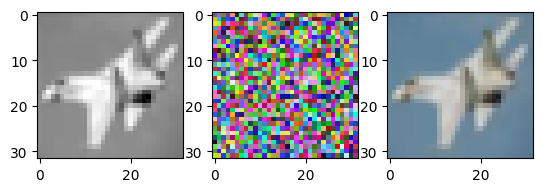

In [121]:
# Visualize an example from the transformed data set
i = 10
y = generator( x_test[0:25] ).numpy()
image = Image.fromarray( ( y[i] * 255 ).astype( 'uint8' ) )
image = np.asarray( image )
fig, ax = plt.subplots(1,3)
ax[2].imshow(y_test[i])
ax[0].imshow(x_test[i], cmap='gray')
ax[1].imshow( image )
plt.show()